# Load df

In [1]:
import pandas as pd
filtered_df = pd.read_csv('study3_responses.redacted.csv')

In [3]:
filtered_df.Condition.value_counts()

Condition
syco       400
nonsyco    400
Name: count, dtype: int64

In [2]:
import numpy as np

filtered_df['scenarioNum'] = np.select(
    [
        filtered_df['pickedScenario'].str.contains('Indirect Communication', case=False, na=False),
        filtered_df['pickedScenario'].str.contains('Relationship Boundaries', case=False, na=False),
        filtered_df['pickedScenario'].str.contains('Making Someone Uncomfortable', case=False, na=False),
        filtered_df['pickedScenario'].str.contains('Involving Yourself in', case=False, na=False),
        filtered_df['pickedScenario'].str.contains('Excluding Someone', case=False, na=False)
    ],
    [
        'passive',
        'relationship',
        'uncomfortable',
        'others',
        'exclusion'
    ],
    default='other'
)


In [3]:
filtered_df['scenarioNum'].value_counts()

scenarioNum
exclusion        205
relationship     199
others           198
uncomfortable    198
Name: count, dtype: int64

In [4]:
filtered_df.Condition.value_counts()

Condition
syco       400
nonsyco    400
Name: count, dtype: int64

In [5]:
import pandas as pd
import statsmodels.formula.api as smf

# --- inputs you already have ---
df = filtered_df.copy()

# Make sure these two binary columns exist (0/1). Adjust names if yours differ.
# If you already have df["is_syco"] / df["is_anthro"], just set these to those names.
syco_col   = "is_syco"   if "is_syco"   in df.columns else "syco"
# anthro_col = "is_anthro" if "is_anthro" in df.columns else "anthro"

# Example: map from your Condition field if needed
if syco_col not in df.columns and "Condition" in df.columns:
    df["syco"] = df["Condition"].map({"nonsyco": 0, "syco": 1})
# if anthro_col not in df.columns and "Anthro" in df.columns:
#     df["anthro"] = df["Anthro"].map({"no": 0, "yes": 1})

dvs = [
    "repair_score",
    "return_likelihood",
    "response_quality",
    "rightorwrong",
    "performance_trust_score",
    "moral_trust_score",
]

label_map = {
    "repair_score": "Repair likelihood",
    "return_likelihood": "Return likelihood",
    "response_quality": "Response quality",
    "rightorwrong": "Rightness judgment",
    "performance_trust_score": "Performance trust",
    "moral_trust_score": "Moral trust",
}

def stars(p):
    if pd.isna(p): return ""
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return ""

def fmt_cell(beta, lo, hi, p):
    return f"{beta:.2f} [{lo:.2f}, {hi:.2f}]{stars(p)}"

def run_models_make_table(df, dvs, syco_col, robust="HC3"):
    rows = []
    for dv in dvs:
        # Fit DV ~ syco * anthro (includes main effects + interaction)
        model = smf.ols(f"{dv} ~ {syco_col} ", data=df).fit(
        )
        # Parameter names
        b_syco = model.params.get(syco_col, float("nan"))
#         b_anth = model.params.get(anthro_col, float("nan"))
        # Patsy names the interaction as 'syco_col:anthro_col'
#         inter_name = f"{syco_col}:{anthro_col}"
#         b_int  = model.params.get(inter_name, float("nan"))

        # 95% CIs
        ci = model.conf_int(alpha=0.05)
        lo_syco, hi_syco = ci.loc[syco_col] if syco_col in ci.index else (float("nan"), float("nan"))
#         lo_anth, hi_anth = ci.loc[anthro_col] if anthro_col in ci.index else (float("nan"), float("nan"))
#         lo_int,  hi_int  = ci.loc[inter_name] if inter_name in ci.index else (float("nan"), float("nan"))

        # p-values
        p_syco = model.pvalues.get(syco_col, float("nan"))
#         p_anth = model.pvalues.get(anthro_col, float("nan"))
#         p_int  = model.pvalues.get(inter_name, float("nan"))

        rows.append({
            "DV": label_map.get(dv, dv),
            "Sycophancy":        fmt_cell(b_syco, lo_syco, hi_syco, p_syco),
#             "Anthropomorphism":  fmt_cell(b_anth, lo_anth, hi_anth, p_anth),
#             "Interaction":       fmt_cell(b_int,  lo_int,  hi_int,  p_int),
        })

    table_df = pd.DataFrame(rows, columns=["DV", "Sycophancy"])

    # Build LaTeX (booktabs) — tweak caption/label as you like
    caption = r"Regression estimates for preregistered model DV $\sim$ Sycophancy. Cells show $\beta$ [95\% CI]. Stars: $* p<.05$, $** p<.01$, $*** p<.001$."
    label = "tab:regression_compact_transposed"
    latex = table_df.to_latex(
        index=False,
        escape=False,      # keep [] and * as-is
        column_format="lccc",
        caption=caption,
        label=label,
        longtable=False,
        bold_rows=False,
        multicolumn=False,
        multicolumn_format="c",
        na_rep="--",
        header=True,
        buf=None,
        position=None,
    )

    return table_df, latex

table_df, latex_str = run_models_make_table(df, dvs, syco_col, 'is_anthro')

print(table_df)   # quick preview in Python
print(latex_str)  # paste into your .tex


                   DV               Sycophancy
0   Repair likelihood  -0.49 [-0.75, -0.22]***
1   Return likelihood     0.61 [0.33, 0.88]***
2    Response quality     0.46 [0.27, 0.66]***
3  Rightness judgment     1.03 [0.81, 1.26]***
4   Performance trust     0.43 [0.23, 0.62]***
5         Moral trust     0.45 [0.22, 0.68]***
\begin{table}
\caption{Regression estimates for preregistered model DV $\sim$ Sycophancy. Cells show $\beta$ [95\% CI]. Stars: $* p<.05$, $** p<.01$, $*** p<.001$.}
\label{tab:regression_compact_transposed}
\begin{tabular}{lccc}
\toprule
DV & Sycophancy \\
\midrule
Repair likelihood & -0.49 [-0.75, -0.22]*** \\
Return likelihood & 0.61 [0.33, 0.88]*** \\
Response quality & 0.46 [0.27, 0.66]*** \\
Rightness judgment & 1.03 [0.81, 1.26]*** \\
Performance trust & 0.43 [0.23, 0.62]*** \\
Moral trust & 0.45 [0.22, 0.68]*** \\
\bottomrule
\end{tabular}
\end{table}



In [127]:
target_vals = ['repair_score',
 'return_likelihood',
 'response_quality',
 'rightorwrong',
 'performance_trust_score',
 'moral_trust_score',]

# Differences across scenarios

In [7]:
target_vals = ['repair_score',
 'return_likelihood',
 'response_quality',
 'rightorwrong',
 'performance_trust_score',
 'moral_trust_score',]

In [10]:
import matplotlib.pyplot as plt
from scipy.stats import sem
import statsmodels.api as sm
from statsmodels.formula.api import ols
# scenarioNum is sginificant for repair_score, response_quality, rightorwrong but not for model trust
# (based on {t} ~ C(scenarioNum) + C(Condition))
for t in target_vals:
    df_plot = filtered_df.dropna(subset=[t, 'Condition', 'scenarioNum'])

    model = ols(f"{t} ~ C(scenarioNum) + C(Condition)", data=df_plot).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"\n### ANOVA for {t} ###")
    print(anova_table)



### ANOVA for repair_score ###
                     sum_sq     df          F    PR(>F)
C(scenarioNum)    76.007537    3.0   7.195546  0.000091
C(Condition)      49.161355    1.0  13.962146  0.000200
Residual        2799.231352  795.0        NaN       NaN

### ANOVA for return_likelihood ###
                     sum_sq     df          F    PR(>F)
C(scenarioNum)    25.876515    3.0   2.168438  0.090339
C(Condition)      71.839326    1.0  18.060293  0.000024
Residual        3162.310985  795.0        NaN       NaN

### ANOVA for response_quality ###
                     sum_sq     df          F    PR(>F)
C(scenarioNum)    15.898813    3.0   2.674637  0.046246
C(Condition)      42.262791    1.0  21.329448  0.000005
Residual        1575.236187  795.0        NaN       NaN

### ANOVA for rightorwrong ###
                     sum_sq     df          F        PR(>F)
C(scenarioNum)    43.146316    3.0   5.341366  1.203069e-03
C(Condition)     219.514787    1.0  81.525529  1.285914e-18
Residual   

In [11]:
for t in target_vals:
    print(t)
    df_plot = filtered_df.dropna(subset=[t, 'Condition', 'scenarioNum'])
    model = ols(f"{t} ~ C(scenarioNum) * C(Condition)", data=df_plot).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table)


repair_score
                                  sum_sq     df          F    PR(>F)
C(scenarioNum)                 76.007537    3.0   7.171974  0.000094
C(Condition)                   49.161355    1.0  13.916409  0.000205
C(scenarioNum):C(Condition)     1.397949    3.0   0.131909  0.941093
Residual                     2797.833403  792.0        NaN       NaN
return_likelihood
                                  sum_sq     df          F    PR(>F)
C(scenarioNum)                 25.876515    3.0   2.166498  0.090572
C(Condition)                   71.839326    1.0  18.044136  0.000024
C(scenarioNum):C(Condition)     9.112335    3.0   0.762926  0.515032
Residual                     3153.198651  792.0        NaN       NaN
response_quality
                                  sum_sq     df          F    PR(>F)
C(scenarioNum)                 15.898813    3.0   2.686455  0.045525
C(Condition)                   42.262791    1.0  21.423694  0.000004
C(scenarioNum):C(Condition)    12.847829    3.0   2.170

In [12]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(
    endog=df_plot[t],
    groups=df_plot["scenarioNum"].astype(str) + "_" + df_plot["Condition"].astype(str),
    alpha=0.05
)
print(tukey.summary())


               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                group2        meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------
    exclusion_nonsyco        exclusion_syco   0.5069 0.3713 -0.2031  1.2168  False
    exclusion_nonsyco        others_nonsyco   0.3252 0.8794 -0.4072  1.0576  False
    exclusion_nonsyco           others_syco   0.3177 0.8814 -0.4003  1.0356  False
    exclusion_nonsyco  relationship_nonsyco  -0.0681    1.0 -0.7913   0.655  False
    exclusion_nonsyco     relationship_syco   0.3854 0.7359  -0.336  1.1068  False
    exclusion_nonsyco uncomfortable_nonsyco  -0.2968 0.9066 -1.0023  0.4086  False
    exclusion_nonsyco    uncomfortable_syco   0.4886 0.4906 -0.2583  1.2356  False
       exclusion_syco        others_nonsyco  -0.1817 0.9941 -0.8896  0.5263  False
       exclusion_syco           others_syco  -0.1892 0.9914 -0.8822  0.5038  False
    

In [13]:
import statsmodels.stats.anova as anova
for t in target_vals:
    print(t)
    df_plot = filtered_df.dropna(subset=[t, 'Condition', 'scenarioNum'])
    model = ols(f"{t} ~ C(scenarioNum) * C(Condition)", data=df_plot).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table)



    for sc in df_plot["scenarioNum"].unique():
        print(sc)
        sub = df_plot[df_plot["scenarioNum"] == sc]
        m = ols(f"{t} ~ C(Condition)", data=sub).fit()
        aov = sm.stats.anova_lm(m, typ=2)
        print(f"\n### Simple effect of Condition within scenario {sc} ###")
        print(aov)


repair_score
                                  sum_sq     df          F    PR(>F)
C(scenarioNum)                 76.007537    3.0   7.171974  0.000094
C(Condition)                   49.161355    1.0  13.916409  0.000205
C(scenarioNum):C(Condition)     1.397949    3.0   0.131909  0.941093
Residual                     2797.833403  792.0        NaN       NaN
others

### Simple effect of Condition within scenario others ###
                  sum_sq     df         F    PR(>F)
C(Condition)   11.334631    1.0  3.453984  0.064599
Residual      643.195672  196.0       NaN       NaN
relationship

### Simple effect of Condition within scenario relationship ###
                  sum_sq     df         F    PR(>F)
C(Condition)   15.659418    1.0  3.844064  0.051332
Residual      802.511437  197.0       NaN       NaN
uncomfortable

### Simple effect of Condition within scenario uncomfortable ###
                  sum_sq     df         F    PR(>F)
C(Condition)   16.565355    1.0  4.957647  0.027114
Re

In [14]:
# ==== Interaction plotting + simple effects + Tukey, loop over all DVs ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

# ---- CONFIG ----
CONDITION_COL = "Condition"
SCENARIO_COL  = "scenarioNum"

def _clean_for_plotting(df, t, condition_col=CONDITION_COL, scenario_col=SCENARIO_COL):
    """Drop NA and coerce groupers to simple 1-D strings to avoid matplotlib multi-dim errors."""
    df_plot = df.dropna(subset=[t, condition_col, scenario_col]).copy()
    # Special-case filter from your original code
    if "Q11" in t:
        df_plot = df_plot.loc[df_plot.index >= 58]

    # Ensure groupers are 1-D simple dtypes (string)
    df_plot[scenario_col] = df_plot[scenario_col].astype(str)
    df_plot[condition_col] = df_plot[condition_col].astype(str)
    return df_plot

def _nice_scenario_sort(values):
    """Sort scenario labels numerically when possible (e.g., '1','2','10'), else lexicographically."""
    def key_fn(x):
        try:
            return (0, int(x))
        except:
            return (1, x)
    return sorted(values, key=key_fn)

def interaction_plot_and_tests(df, t, condition_col=CONDITION_COL, scenario_col=SCENARIO_COL,
                               do_tukey=True):
    # 1) Clean & prep
    df_plot = _clean_for_plotting(df, t, condition_col, scenario_col)

    # 2) Fit interaction model and print ANOVA (Type II)
    model = ols(f"{t} ~ C({scenario_col}) * C({condition_col})", data=df_plot).fit()
    aov = sm.stats.anova_lm(model, typ=2)
    print(f"\n==============================")
    print(f"### ANOVA with interaction for {t} ###")
    print(aov)

    # 3) Plot interaction (means ± 95% CI); seaborn API compatible across versions
#     plt.figure(figsize=(8, 6))
#     # If your seaborn is older, ci=95 works universally; newer accepts errorbar=("ci",95)
#     sns.pointplot(
#         data=df_plot,
#         x=scenario_col, y=t, hue=condition_col,
#         dodge=True, ci=95, join=True
#     )
#     label_t = t.replace("Q11", "repair")
#     plt.title(f"Interaction: {label_t}")
#     plt.ylabel(f"Mean {label_t}")
#     plt.xlabel("Scenario")
#     plt.tight_layout()
#     plt.show()

    # 4) Simple effects of Condition within each scenario (1-way ANOVA per scenario)
    print(f"\n### Simple effects of {condition_col} within each {scenario_col} for {t} ###")
    rows = []
    scenarios = _nice_scenario_sort(df_plot[scenario_col].unique())
    for sc in scenarios:
        sub = df_plot[df_plot[scenario_col] == sc]
        # Must have at least 2 condition levels to test
        if sub[condition_col].nunique() < 2:
            continue
        m = ols(f"{t} ~ C({condition_col})", data=sub).fit()
        a = sm.stats.anova_lm(m, typ=2)
        # Gracefully handle if the row name differs
        row_name = [r for r in a.index if r.startswith(f"C({condition_col})")]
        if not row_name:
            continue
        row = row_name[0]
        F = a.loc[row, "F"]
        p = a.loc[row, "PR(>F)"]
        rows.append((sc, F, p))

    if rows:
        scs, Fs, ps = zip(*rows)
        reject, p_adj, _, _ = multipletests(ps, method="fdr_bh")
        print("scenario\tF\tp\tp_FDR\tSig(BH)")
        for sc, F, p, padj, sig in zip(scs, Fs, ps, p_adj, reject):
            print(f"{sc}\t{F:.3f}\t{p:.4g}\t{padj:.4g}\t{'*' if sig else ''}")
    else:
        print("(No scenarios had ≥2 Condition levels; simple effects skipped.)")

    # 5) Optional: Tukey HSD across all scenario×condition cells
    if do_tukey:
        print(f"\n### Tukey HSD on scenario×condition cells for {t} ###")
        try:
            groups = df_plot[scenario_col].astype(str) + "_" + df_plot[condition_col].astype(str)
            tukey = pairwise_tukeyhsd(endog=df_plot[t], groups=groups, alpha=0.05)
            print(tukey.summary())
        except Exception as e:
            print("Tukey failed:", e)

# ===== Run for all DVs =====
for t in target_vals:
    interaction_plot_and_tests(filtered_df, t, do_tukey=True)



### ANOVA with interaction for repair_score ###
                                  sum_sq     df          F    PR(>F)
C(scenarioNum)                 76.007537    3.0   7.171974  0.000094
C(Condition)                   49.161355    1.0  13.916409  0.000205
C(scenarioNum):C(Condition)     1.397949    3.0   0.131909  0.941093
Residual                     2797.833403  792.0        NaN       NaN

### Simple effects of Condition within each scenarioNum for repair_score ###
scenario	F	p	p_FDR	Sig(BH)
exclusion	2.038	0.1549	0.1549	
others	3.454	0.0646	0.08613	
relationship	3.844	0.05133	0.08613	
uncomfortable	4.958	0.02711	0.08613	

### Tukey HSD on scenario×condition cells for repair_score ###
               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                group2        meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------
    exclusion_nonsyco        exclusion_syco  -0.3703 0.

               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                group2        meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------
    exclusion_nonsyco        exclusion_syco   1.0119 0.0003  0.3127   1.711   True
    exclusion_nonsyco        others_nonsyco   -0.602 0.1868 -1.3267  0.1228  False
    exclusion_nonsyco           others_syco   0.5705 0.2178 -0.1365  1.2775  False
    exclusion_nonsyco  relationship_nonsyco   0.0038    1.0 -0.7117  0.7193  False
    exclusion_nonsyco     relationship_syco   1.0417 0.0003  0.3279  1.7554   True
    exclusion_nonsyco uncomfortable_nonsyco   0.0529    1.0 -0.6433  0.7491  False
    exclusion_nonsyco    uncomfortable_syco    1.033 0.0006  0.2937  1.7724   True
       exclusion_syco        others_nonsyco  -1.6138    0.0 -2.3169 -0.9107   True
       exclusion_syco           others_syco  -0.4413 0.5106  -1.126  0.2434  False
    

# Correlations

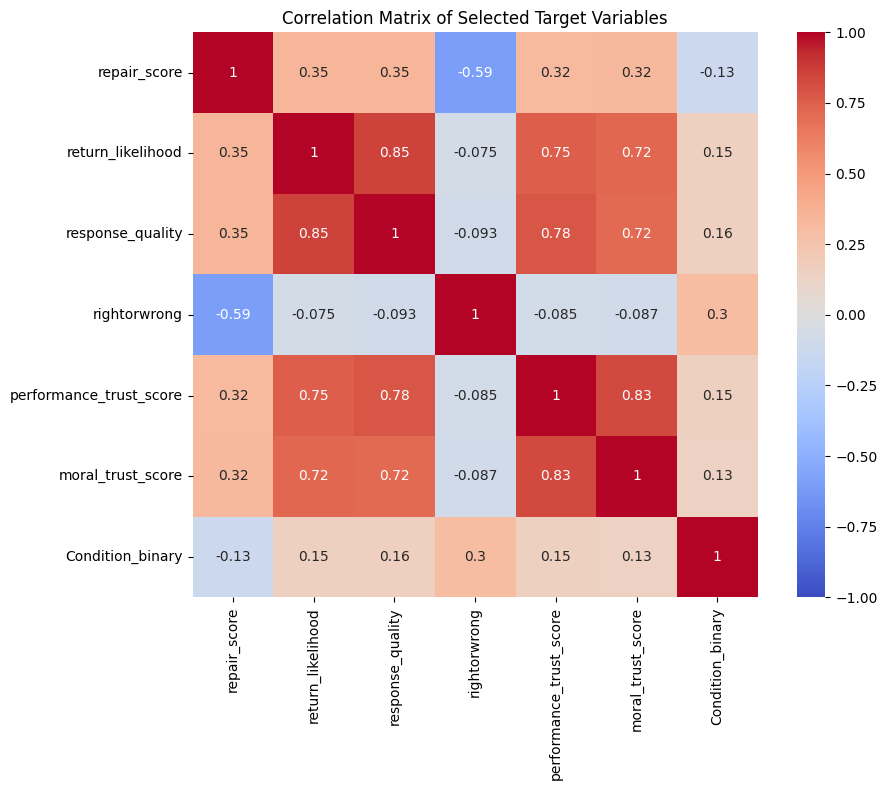

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# target_vals is a list of column names in filtered_d
# Example: target_vals = ['label_a', 'label_b', 'label_c']
filtered_df['Condition_binary'] = filtered_df['Condition'].map({'nonsyco': 0, 'syco': 1})

# Subset the DataFrame to just those columns
target_df = filtered_df[['repair_score',
 'return_likelihood',
 'response_quality',
 'rightorwrong',
 'performance_trust_score',
 'moral_trust_score',
                         'Condition_binary']]

# Optionally convert to numeric (if necessary, e.g., if 0/1 are stored as strings)
target_df = target_df.apply(pd.to_numeric, errors='coerce')

# Compute correlation matrix
corr_matrix = target_df.corr(method='pearson')  # Or 'spearman' if non-linear

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title('Correlation Matrix of Selected Target Variables')
plt.tight_layout()
plt.show()


In [17]:
aias_cols = ['AIAS_1', 'AIAS_2', 'AIAS_3', 'AIAS_4']  # update with your actual column names
filtered_df['AIAS_comp'] = filtered_df[aias_cols].mean(axis=1)


In [18]:
# Mapping dictionary
likert_map = {
    "Disagree strongly": -2,
    "Disagree a little": -1,
    "Neither agree nor disagree": 0,
    "Agree a little": 1,
    "Agree strongly": 2
}

# Identify all relevant columns
big_five_cols = [col for col in filtered_df.columns if col.startswith("big_five_")]

# Apply the mapping to each column
for col in big_five_cols:
    filtered_df[col + "_num"] = filtered_df[col].map(likert_map)
    
    

In [19]:
# Step 2: Traits mapping
trait_map = {
    "big_five_1": ("Extraversion", True),      # reverse-coded
    "big_five_2": ("Agreeableness", False),
    "big_five_3": ("Conscientiousness", True), # reverse-coded
    "big_five_4": ("Neuroticism", True),       # reverse-coded
    "big_five_5": ("Openness", True),          # reverse-coded
    "big_five_6": ("Extraversion", False),
    "big_five_7": ("Agreeableness", True),     # reverse-coded
    "big_five_8": ("Conscientiousness", False),
    "big_five_9": ("Neuroticism", False),
    "big_five_10": ("Openness", False)
}

# Step 3: Map text responses to numeric values
for col in trait_map:
    filtered_df[col + "_num"] = filtered_df[col].map(likert_map)

# Step 4: Reverse-code relevant items
for col, (_, reverse) in trait_map.items():
    num_col = col + "_num"
    if reverse:
        filtered_df[num_col] = filtered_df[num_col] * -1

# Step 5: Optional — calculate average for each Big Five trait
traits = ["Extraversion", "Agreeableness", "Conscientiousness", "Neuroticism", "Openness"]
for trait in traits:
    trait_cols = [col + "_num" for col, (t, _) in trait_map.items() if t == trait]
    filtered_df[f"{trait}_avg"] = filtered_df[trait_cols].mean(axis=1)


In [20]:
comma_counts = filtered_df['AI_awareness'].str.count(',')+1
filtered_df['awareness' + "_num"]=(comma_counts)

In [21]:
comma_counts = filtered_df['Q27'].str.count(',')+1
filtered_df['use' + "_num"]=(comma_counts)

In [27]:
filtered_df.awareness_num.value_counts()

awareness_num
3.0    181
4.0    160
5.0    146
2.0    134
6.0     92
7.0     46
1.0     34
8.0      6
Name: count, dtype: int64

In [22]:
filtered_df.use_num.value_counts()

use_num
2.0    238
1.0    206
3.0    184
4.0     87
5.0     35
6.0     18
7.0      3
8.0      1
Name: count, dtype: int64

In [23]:
filtered_df.frequency.value_counts()

frequency
A few times a week       309
Daily                    213
A few times a month      149
Once every few months     92
Never                     34
Name: count, dtype: int64

In [24]:
frequency_map = {
    "Never": 0,
    "Once every few months": 1,
    "A few times a month": 2,
    "A few times a week": 3,
    "Daily": 4
}
col = 'frequency'
filtered_df[col + "_num"] = filtered_df[col].map(frequency_map)

In [26]:
filtered_df['frequency_num'].value_counts()

frequency_num
3.0    309
4.0    213
2.0    149
1.0     92
0.0     34
Name: count, dtype: int64

In [28]:
filtered_df["is_syco"] = filtered_df["Condition"].map({"nonsyco": 0, "syco": 1})


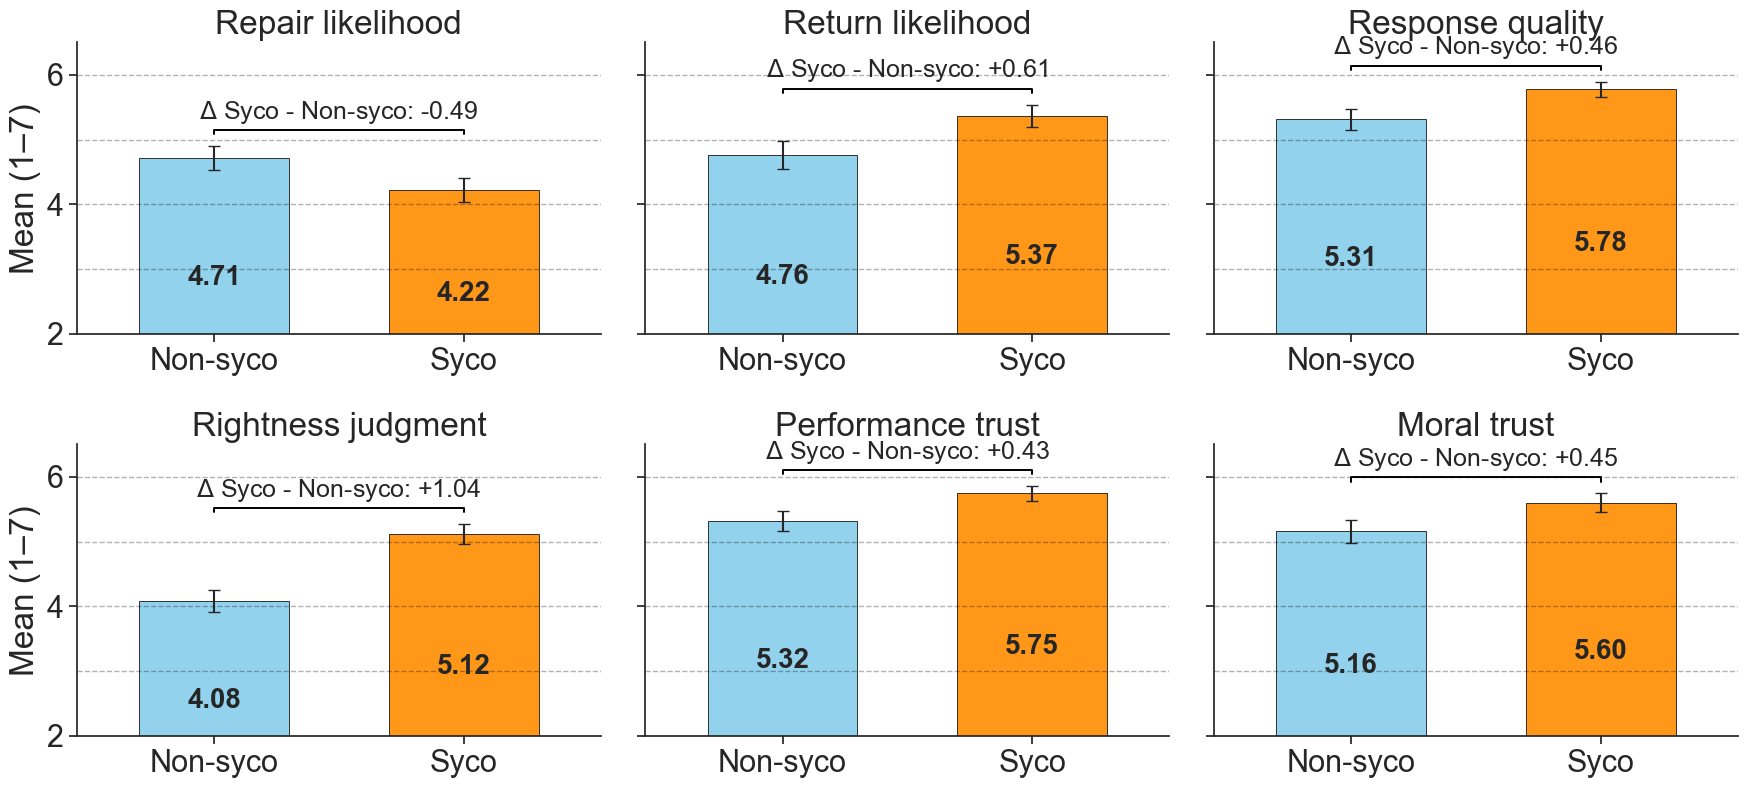

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# --- style ---
sns.set_context("paper")
sns.set(font_scale=2.0)
sns.set_style("white", {"font.family": "sans-serif", "font.serif": ['Helvetica']})
sns.set_style("ticks", {"xtick.major.size": 4, "ytick.major.size": 4})

def apply_style(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for yy in np.arange(2, 7, 1):
        ax.axhline(y=yy, linestyle='--', color='black', linewidth=1, alpha=0.3)

def annotate_bar_means(ax, decimals=2, fontsize=11):
    for rect in ax.patches:
        h = rect.get_height()
        if not np.isfinite(h): continue
        x = rect.get_x() + rect.get_width()/2
        y = rect.get_y() + h/2
        ax.text(x, y+0.5, f"{h:.{decimals}f}",
                ha="center", va="center", fontsize=fontsize, fontweight="bold")

def effect_and_ci(m1, s1, n1, m0, s0, n0):
    diff = m1 - m0
    se_diff = np.sqrt((s1**2)/n1 + (s0**2)/n0)
    ci = 1.96 * se_diff
    return diff, diff - ci, diff + ci

def add_cluster_bracket(ax, x_left, x_right, y_top, text,
                        base_pad=0.04, tick=0.015, lw=1.4, fs=12):
    y0, y1 = ax.get_ylim()
    yr = y1 - y0
    h = y_top + base_pad * yr
    v = h + tick * yr
    ax.plot([x_left, x_left, x_right, x_right], [h, v, v, h],
            c="black", lw=lw, zorder=4, clip_on=False)
    ax.text((x_left + x_right)/2, v + tick*yr, text,
            ha="center", va="bottom", fontsize=18,
            bbox=dict(boxstyle='round,pad=0.2', fc='none', ec='none', alpha=0.95),
            zorder=5, clip_on=False)

# --- inputs ---
df_source = filtered_df  # should already have col is_syco = {0,1}

target_vals = [
    'repair_score',
    'return_likelihood',
    'response_quality',
    'rightorwrong',
    'performance_trust_score',
    'moral_trust_score',
]

label_map = {
    "repair_score": "Repair likelihood",
    "return_likelihood": "Return likelihood",
    "response_quality": "Response quality",
    "rightorwrong": "Rightness judgment",
    "performance_trust_score": "Performance trust",
    "moral_trust_score": "Moral trust",
}

# --- layout ---
num_vars = len(target_vals)
cols = 3
rows = math.ceil(num_vars / cols)
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4.2*rows), sharey=True)
axes = axes.flatten()

colors = ["skyblue", "darkorange"]

for i, t in enumerate(target_vals):
    df_plot = df_source.dropna(subset=[t, 'is_syco'])

    grouped = df_plot.groupby('is_syco')[t]
    means  = grouped.mean().reindex([0,1])
    stds   = grouped.std().reindex([0,1])
    ns     = grouped.count().reindex([0,1])
    errors = stds / np.sqrt(ns)

    ax = axes[i]
    means.plot.bar(
        yerr=1.96 * errors,
        capsize=4,
        ax=ax,
        alpha=0.9,
        color=colors,
        width=0.6,
        edgecolor="black",
        linewidth=0.6
    )

    ax.set_title(label_map[t])
    ax.set_ylabel("Mean (1–7)")
    ax.set_xticks([0,1])
    ax.set_xticklabels(['Non-syco', 'Syco'], rotation=0)
    ax.set_xlabel('')

    bar_tops = (means + 1.96 * errors).values
    top_est = np.nanmax(bar_tops)
    upper = max(6.5, min(7.2, top_est + 0.35))
    ax.set_ylim(2, upper)

    apply_style(ax)
    annotate_bar_means(ax, decimals=2, fontsize=20)

    if ns.min() > 1 and np.isfinite(means.values).all():
        diff, lo, hi = effect_and_ci(
            means.loc[1], stds.loc[1], ns.loc[1],
            means.loc[0], stds.loc[0], ns.loc[0]
        )
        add_cluster_bracket(ax, 0, 1, top_est,
                            f"$\Delta$ Syco - Non-syco: {diff:+.2f}")

plt.tight_layout()
plt.savefig("figure_bar_means_syco_study3.pdf", bbox_inches="tight")
plt.savefig("figure_bar_means_syco_study3.png", dpi=300, bbox_inches="tight")
plt.show()


In [31]:
# --- collect summary stats for saving ---
summary_list = []

for i, t in enumerate(target_vals):
    df_plot = df_source.dropna(subset=[t, 'is_syco'])

    grouped = df_plot.groupby('is_syco')[t]
    means  = grouped.mean().reindex([0, 1])
    stds   = grouped.std().reindex([0, 1])
    ns     = grouped.count().reindex([0, 1])
    errors = stds / np.sqrt(ns)

    # append to summary table
    for cond in [0, 1]:  # 0 = Non-syco, 1 = Syco
        summary_list.append({
            "dv": t,
            "label": label_map[t],
            "is_syco": cond,
            "mean": means.loc[cond],
            "std": stds.loc[cond],
            "n": ns.loc[cond],
            "sem": errors.loc[cond],
            "ci95": 1.96 * errors.loc[cond],
            'study':'study3',
        })

# turn into DataFrame
summary_df = pd.DataFrame(summary_list)

# save
summary_df.to_csv("study3_bar_means_summary.csv", index=False)


# Additional covariates

In [32]:
import pandas as pd


# split on commas, stack into one column, strip spaces
race_counts = (
    filtered_df['race']
    .dropna()
    .str.split(",")
    .explode()
    .str.strip()
    .value_counts()
)

print(race_counts)


race
White or Caucasian                                  619
Black or African American                           119
Asian                                                53
American Indian/Native American or Alaska Native     28
Other                                                27
Prefer not to say                                     5
Native Hawaiian or Other Pacific Islander             3
Name: count, dtype: int64


In [33]:
filtered_df['gender'].value_counts()

gender
Female                       431
Male                         351
Non-binary / third gender     10
Prefer not to say              3
Prefer to self-describe        1
Name: count, dtype: int64

In [34]:
from scipy.stats import f_oneway, kruskal
import pandas as pd

for i, t in enumerate(['repair_score',
#  'trust_score',
 'return_likelihood',
 'response_quality',
 'rightorwrong',
 'performance_trust_score',
 'moral_trust_score',]):
    print(f"\nTesting: {t}")

    # Drop NaNs
    df_plot = filtered_df.dropna(subset=[t, 'scenarioNum'])

    # Group values by scenarioNum
    grouped_values = [group[t].values for name, group in df_plot.groupby('scenarioNum')]

    # Check normality and variance assumptions if needed — skipping here

    # One-way ANOVA
    try:
        f_stat, p_val = f_oneway(*grouped_values)
        print(f"ANOVA p-value: {p_val:.4f}")
    except Exception as e:
        print(f"ANOVA failed: {e}")

    # Kruskal-Wallis test
    try:
        h_stat, kw_p = kruskal(*grouped_values)
        print(f"Kruskal-Wallis p-value: {kw_p:.4f}")
    except Exception as e:
        print(f"Kruskal-Wallis failed: {e}")



Testing: repair_score
ANOVA p-value: 0.0001
Kruskal-Wallis p-value: 0.0001

Testing: return_likelihood
ANOVA p-value: 0.0775
Kruskal-Wallis p-value: 0.0625

Testing: response_quality
ANOVA p-value: 0.0408
Kruskal-Wallis p-value: 0.0831

Testing: rightorwrong
ANOVA p-value: 0.0054
Kruskal-Wallis p-value: 0.0054

Testing: performance_trust_score
ANOVA p-value: 0.0782
Kruskal-Wallis p-value: 0.0596

Testing: moral_trust_score
ANOVA p-value: 0.3736
Kruskal-Wallis p-value: 0.6334


# Scenario covariates

In [35]:
import statsmodels.formula.api as smf
import pandas as pd
# ---- variable name mapping ----
var_labels = {
    "Intercept": "Intercept",
    'C(scenarioNum)[T.2]':'Scenario 2',
    'C(scenarioNum)[T.3]':'Scenario 3',
    'C(scenarioNum)[T.4]':'Scenario 4',
    "is_syco[T.True]": "Sycophancy",
    "is_anthro[T.True]": "Anthropomorphism",
    "is_syco[T.True]:is_anthro[T.True]": "Syco × Anthro",
    "heard_of_num": "Heard of AI (num)",
    "used_num": "Used AI (num)",
    "Extraversion_avg": "Extraversion",
    "Agreeableness_avg": "Agreeableness",
    "Conscientiousness_avg": "Conscientiousness",
    "Neuroticism_avg": "Neuroticism",
    "Openness_avg": "Openness",
    "AIAS_comp": "AI Attitudes",
#     frequency_cat[T.A few times a month]
    "frequency_cat[T.Once every few months]": "Freq: Few months",
    "frequency_cat[T.A few times a month]": "Freq: Few/month",
    "frequency_cat[T.A few times a week]": "Freq: Few/week",
    "frequency_cat[T.Daily]": "Freq: Daily",
    "age": "Age",
    "C(gender_cat, Treatment('female'))[T.male]": "Male",
    "C(gender_cat, Treatment('female'))[T.nonbinary]": "Nonbinary",
    "C(race_cat, Treatment('White or Caucasian'))[T.Black or African American]": "Black",
    "C(race_cat, Treatment('White or Caucasian'))[T.Asian]": "Asian",
    "C(race_cat, Treatment('White or Caucasian'))[T.American Indian/Native American or Alaska Native]": "Native American",
    "C(race_cat, Treatment('White or Caucasian'))[T.Native Hawaiian or Other Pacific Islander]": "NH/PI",
    "C(race_cat, Treatment('White or Caucasian'))[T.Other]": "Other race",
    "C(race_cat, Treatment('White or Caucasian'))[T.Prefer not to say]": "Prefer not say",
    
}
tables = {}
filtered_df["syco"] = filtered_df["Condition"].map({"nonsyco": 0, "syco": 1})

for dv in target_vals:
    tdf = filtered_df.dropna(subset=[dv, 'scenarioNum'])
    model = smf.ols(f"{dv} ~ syco + C(scenarioNum)", data=tdf).fit()
    tables[dv] = model

# Build a LaTeX summary table
from statsmodels.iolib.summary2 import summary_col

latex_table = summary_col(
    results=list(tables.values()),
    float_format="%.3f",
    stars=True,
    model_names=[label_map[x] for x in list(tables.keys())],
    info_dict={"N":lambda x: f"{int(x.nobs)}"}
).as_latex()


for raw, pretty in var_labels.items():
    print(raw)
    latex_table = latex_table.replace('\_','_').replace(raw, pretty)

print(latex_table)

# print(latex_table)


Intercept
C(scenarioNum)[T.2]
C(scenarioNum)[T.3]
C(scenarioNum)[T.4]
is_syco[T.True]
is_anthro[T.True]
is_syco[T.True]:is_anthro[T.True]
heard_of_num
used_num
Extraversion_avg
Agreeableness_avg
Conscientiousness_avg
Neuroticism_avg
Openness_avg
AIAS_comp
frequency_cat[T.Once every few months]
frequency_cat[T.A few times a month]
frequency_cat[T.A few times a week]
frequency_cat[T.Daily]
age
C(gender_cat, Treatment('female'))[T.male]
C(gender_cat, Treatment('female'))[T.nonbinary]
C(race_cat, Treatment('White or Caucasian'))[T.Black or African American]
C(race_cat, Treatment('White or Caucasian'))[T.Asian]
C(race_cat, Treatment('White or Caucasian'))[T.American Indian/Native American or Alaska Native]
C(race_cat, Treatment('White or Caucasian'))[T.Native Hawaiian or Other Pacific Islander]
C(race_cat, Treatment('White or Caucasian'))[T.Other]
C(race_cat, Treatment('White or Caucasian'))[T.Prefer not to say]
\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lllllll}
\hlin

In [36]:
filtered_df['heard_of_num'] = filtered_df['AI_awareness'].str.count(',') + 1
filtered_df['used_num'] = filtered_df['Q27'].str.count(',') + 1


In [38]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

# Helper: format coefficient ± SE with stars
def format_coef(row):
    coef, se, p = row["coef"], row["se"], row["pval"]
    stars = ""
    if p < 0.001:
        stars = "***"
    elif p < 0.01:
        stars = "**"
    elif p < 0.05:
        stars = "*"
    return f"{coef:.3f}{stars}  \\newline ({se:.3f})"

results = {}
# ---- variable name mapping ----
var_labels = {
    "Intercept": "Intercept",
    'C(scenarioNum)[T.2]':'Scenario 2',
    'C(scenarioNum)[T.3]':'Scenario 3',
    'C(scenarioNum)[T.4]':'Scenario 4',
    "is_syco[T.True]": "Sycophancy",
    "is_anthro[T.True]": "Anthropomorphism",
    "is_syco[T.True]:is_anthro[T.True]": "Syco × Anthro",
    "heard_of_num": "Heard of AI (num)",
    "used_num": "Used AI (num)",
    "Extraversion_avg": "Extraversion",
    "Agreeableness_avg": "Agreeableness",
    "Conscientiousness_avg": "Conscientiousness",
    "Neuroticism_avg": "Neuroticism",
    "Openness_avg": "Openness",
    "AIAS_comp": "AI Attitudes",
#     frequency_cat[T.A few times a month]
    "frequency_cat[T.Once every few months]": "Freq: Few months",
    "frequency_cat[T.A few times a month]": "Freq: Few/month",
    "frequency_cat[T.A few times a week]": "Freq: Few/week",
    "frequency_cat[T.Daily]": "Freq: Daily",
    "age": "Age",
    "C(gender_cat, Treatment('female'))[T.male]": "Male",
    "C(gender_cat, Treatment('female'))[T.nonbinary]": "Nonbinary",
    "C(race_cat, Treatment('White or Caucasian'))[T.Black or African American]": "Black",
    "C(race_cat, Treatment('White or Caucasian'))[T.Asian]": "Asian",
    "C(race_cat, Treatment('White or Caucasian'))[T.American Indian/Native American or Alaska Native]": "Native American",
    "C(race_cat, Treatment('White or Caucasian'))[T.Native Hawaiian or Other Pacific Islander]": "NH/PI",
    "C(race_cat, Treatment('White or Caucasian'))[T.Other]": "Other race",
    "C(race_cat, Treatment('White or Caucasian'))[T.Prefer not to say]": "Prefer not say",
    
}



label_map = {
    "repair_score": "Repair likelihood",
    "return_likelihood": "Return likelihood",
    "response_quality": "Response quality",
    "rightorwrong": "Rightness judgment",
    "performance_trust_score": "Performance trust",
    "moral_trust_score": "Moral trust",
}

for dv in target_vals:
    try:
        needed_cols = [
            dv, "syco", "heard_of_num", "used_num",
            "Extraversion_avg", "Agreeableness_avg", "Conscientiousness_avg",
            "Neuroticism_avg", "Openness_avg", "AIAS_comp", "age",
            "gender_cat", "race_cat",'frequency_cat'
        ]
        tdf = filtered_df.dropna(subset=needed_cols)

        model = smf.ols(
            f"""{dv} ~ syco + heard_of_num + used_num +
                 Extraversion_avg + Agreeableness_avg + Conscientiousness_avg +
                 Neuroticism_avg + Openness_avg + AIAS_comp + age + frequency_cat + 
                 C(gender_cat, Treatment('female')) +
                 C(race_cat, Treatment('White or Caucasian'))
            """,
            data=tdf
        ).fit(cov_type="HC3")

        summary_df = pd.concat(
            [model.params, model.bse, model.pvalues],
            axis=1
        )
        summary_df.columns = ['coef', 'se', 'pval']

        results[label_map[dv]] = summary_df

    except Exception as e:
        print(f"Error fitting {dv}:", e)


# --- Build LaTeX table ---
# Row index: all predictors across models

# ---- build LaTeX table ----
all_vars = sorted(set().union(*[df.index for df in results.values()]))
rows = []
for var in all_vars:
    label = var_labels.get(var, var)  # shorten name if mapping exists
    row = [label]
    for dv in target_vals:
        if var in results[label_map[dv]].index:
            row.append(format_coef(results[label_map[dv]].loc[var]))
        else:
            row.append("")
    rows.append(row)

latex = "\\begin{table}[ht]\n\\centering\n"
latex += "\\begin{tabular}{l" + "c" * len(target_vals) + "}\n"
latex += "\\hline\n"
latex += " & " + " & ".join([label_map[dv] for dv in target_vals]) + " \\\\\n"
latex += "\\hline\n"

for r in rows:
    latex += " & ".join(r) + " \\\\\n"

latex += "\\hline\n"
latex += "\\end{tabular}\n"
latex += "\\caption{OLS regression results with robust SEs. Coefficients with SEs in parentheses. * p<0.05, ** p<0.01, *** p<0.001.}\n"
latex += "\\label{tab:regressionvignette}\n"
latex += "\\end{table}"

print(latex)


\begin{table}[ht]
\centering
\begin{tabular}{lcccccc}
\hline
 & Repair likelihood & Return likelihood & Response quality & Rightness judgment & Performance trust & Moral trust \\
\hline
AI Attitudes & 0.160***  \newline (0.041) & 0.432***  \newline (0.038) & 0.284***  \newline (0.028) & -0.011  \newline (0.038) & 0.368***  \newline (0.031) & 0.406***  \newline (0.034) \\
Agreeableness & 0.234**  \newline (0.081) & 0.210**  \newline (0.074) & 0.168**  \newline (0.056) & -0.031  \newline (0.072) & 0.104*  \newline (0.048) & 0.109  \newline (0.057) \\
Male & 0.012  \newline (0.145) & -0.002  \newline (0.132) & -0.078  \newline (0.095) & 0.165  \newline (0.130) & -0.047  \newline (0.089) & -0.008  \newline (0.106) \\
Nonbinary & -0.668  \newline (0.859) & 0.088  \newline (0.799) & 0.125  \newline (0.520) & -0.507  \newline (0.570) & -0.112  \newline (0.600) & -0.486  \newline (0.674) \\
Native American & -0.096  \newline (0.554) & 0.027  \newline (0.816) & -0.244  \newline (0.525) & 0.365 

# Full Regression with participant traits and scenarios

In [39]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

# Helper: format coefficient ± SE with stars
def format_coef(row):
    coef, se, p = row["coef"], row["se"], row["pval"]
    stars = ""
    if p < 0.001:
        stars = "***"
    elif p < 0.01:
        stars = "**"
    elif p < 0.05:
        stars = "*"
    return f"{coef:.3f}{stars}  \\newline ({se:.3f})"

results = {}
# ---- variable name mapping ----
var_labels = {
    "Intercept": "Intercept",
    'C(scenarioNum)[T.2]':'Scenario 2',
    'C(scenarioNum)[T.3]':'Scenario 3',
    'C(scenarioNum)[T.4]':'Scenario 4',
    "is_syco[T.True]": "Sycophancy",
    "is_anthro[T.True]": "Anthropomorphism",
    "is_syco[T.True]:is_anthro[T.True]": "Syco × Anthro",
    "heard_of_num": "Heard of AI (num)",
    "used_num": "Used AI (num)",
    "Extraversion_avg": "Extraversion",
    "Agreeableness_avg": "Agreeableness",
    "Conscientiousness_avg": "Conscientiousness",
    "Neuroticism_avg": "Neuroticism",
    "Openness_avg": "Openness",
    "AIAS_comp": "AI Attitudes",
#     frequency_cat[T.A few times a month]
    "frequency_cat[T.Once every few months]": "Freq: Few months",
    "frequency_cat[T.A few times a month]": "Freq: Few/month",
    "frequency_cat[T.A few times a week]": "Freq: Few/week",
    "frequency_cat[T.Daily]": "Freq: Daily",
    "age": "Age",
    "C(gender_cat, Treatment('female'))[T.male]": "Male",
    "C(gender_cat, Treatment('female'))[T.nonbinary]": "Nonbinary",
    "C(race_cat, Treatment('White or Caucasian'))[T.Black or African American]": "Black",
    "C(race_cat, Treatment('White or Caucasian'))[T.Asian]": "Asian",
    "C(race_cat, Treatment('White or Caucasian'))[T.American Indian/Native American or Alaska Native]": "Native American",
    "C(race_cat, Treatment('White or Caucasian'))[T.Native Hawaiian or Other Pacific Islander]": "NH/PI",
    "C(race_cat, Treatment('White or Caucasian'))[T.Other]": "Other race",
    "C(race_cat, Treatment('White or Caucasian'))[T.Prefer not to say]": "Prefer not say",
    
}



label_map = {
    "repair_score": "Repair likelihood",
    "return_likelihood": "Return likelihood",
    "response_quality": "Response quality",
    "rightorwrong": "Rightness judgment",
    "performance_trust_score": "Performance trust",
    "moral_trust_score": "Moral trust",
}

for dv in target_vals:
    try:
        needed_cols = [
            dv, "syco", "heard_of_num", "used_num",
            "Extraversion_avg", "Agreeableness_avg", "Conscientiousness_avg",
            "Neuroticism_avg", "Openness_avg", "AIAS_comp", "age",
            "gender_cat", "race_cat",'frequency_cat','scenarioNum'
        ]
        tdf = filtered_df.dropna(subset=needed_cols)

        model = smf.ols(
            f"""{dv} ~ syco + heard_of_num + used_num +
                 Extraversion_avg + Agreeableness_avg + Conscientiousness_avg +
                 Neuroticism_avg + Openness_avg + AIAS_comp + age + frequency_cat + 
                 C(gender_cat, Treatment('female')) +
                 C(race_cat, Treatment('White or Caucasian')) + C(scenarioNum)
            """,
            data=tdf
        ).fit(cov_type="HC3")

        summary_df = pd.concat(
            [model.params, model.bse, model.pvalues],
            axis=1
        )
        summary_df.columns = ['coef', 'se', 'pval']

        results[label_map[dv]] = summary_df

    except Exception as e:
        print(f"Error fitting {dv}:", e)


# --- Build LaTeX table ---
# Row index: all predictors across models

# ---- build LaTeX table ----
all_vars = sorted(set().union(*[df.index for df in results.values()]))
rows = []
for var in all_vars:
    label = var_labels.get(var, var)  # shorten name if mapping exists
    row = [label]
    for dv in target_vals:
        if var in results[label_map[dv]].index:
            row.append(format_coef(results[label_map[dv]].loc[var]))
        else:
            row.append("")
    rows.append(row)

latex = "\\begin{table}[ht]\n\\centering\n"
latex += "\\begin{tabular}{l" + "c" * len(target_vals) + "}\n"
latex += "\\hline\n"
latex += " & " + " & ".join([label_map[dv] for dv in target_vals]) + " \\\\\n"
latex += "\\hline\n"

for r in rows:
    latex += " & ".join(r) + " \\\\\n"

latex += "\\hline\n"
latex += "\\end{tabular}\n"
latex += "\\caption{OLS regression results with robust SEs. Coefficients with SEs in parentheses. * p<0.05, ** p<0.01, *** p<0.001.}\n"
latex += "\\label{tab:regressionvignette}\n"
latex += "\\end{table}"

print(latex)



\begin{table}[ht]
\centering
\begin{tabular}{lcccccc}
\hline
 & Repair likelihood & Return likelihood & Response quality & Rightness judgment & Performance trust & Moral trust \\
\hline
AI Attitudes & 0.154***  \newline (0.041) & 0.430***  \newline (0.038) & 0.282***  \newline (0.029) & -0.006  \newline (0.037) & 0.367***  \newline (0.031) & 0.404***  \newline (0.034) \\
Agreeableness & 0.241**  \newline (0.080) & 0.214**  \newline (0.074) & 0.171**  \newline (0.056) & -0.035  \newline (0.071) & 0.105*  \newline (0.048) & 0.110  \newline (0.057) \\
Male & 0.046  \newline (0.143) & 0.016  \newline (0.133) & -0.069  \newline (0.096) & 0.155  \newline (0.129) & -0.049  \newline (0.090) & -0.002  \newline (0.107) \\
Nonbinary & -0.664  \newline (0.949) & 0.071  \newline (0.775) & 0.118  \newline (0.506) & -0.572  \newline (0.556) & -0.063  \newline (0.586) & -0.459  \newline (0.679) \\
Native American & -0.199  \newline (0.588) & -0.033  \newline (0.822) & -0.302  \newline (0.531) & 0.474 

# Moderators

In [33]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

# -------------------- CONFIG --------------------
CENTER_CONTINUOUS = True

continuous_mods = [
    "heard_of_num", "used_num",
    "Extraversion_avg", "Agreeableness_avg", "Conscientiousness_avg",
    "Neuroticism_avg", "Openness_avg", "AIAS_comp", "age"
]
categorical_mods = ["frequency_cat", "gender_cat", "race_cat"]

gender_baseline = "female"
race_baseline   = "White or Caucasian"

# Assumed provided by you:
# target_vals = [...]     # list of DV column names
# label_map = {...}       # dict DV -> pretty label (or use DV if missing)
# filtered_df = ...       # your DataFrame

# -------------------- PREP --------------------
work_df = filtered_df.copy()

# Make numeric 0/1 treatment variable for robust interactions
# Handles bool, 'True'/'False', or 0/1 gracefully
work_df["is_syco_num"] = work_df["is_syco"].astype(int)

# Optional: also make numeric version for is_anthro to avoid categorical naming quirks
# if pd.api.types.is_bool_dtype(work_df["is_anthro"]) or work_df["is_anthro"].dropna().isin([0,1,True,False]).all():
#     work_df["is_anthro_num"] = work_df["is_anthro"].astype(int)
#     anthro_name = "is_anthro_num"
# else:
#     anthro_name = "is_anthro"

# Center continuous moderators
def center_inplace(df, cols):
    for c in cols:
        if c in df.columns:
            df[c + "_c"] = df[c] - df[c].mean()

if CENTER_CONTINUOUS:
    center_inplace(work_df, continuous_mods)
    cont_use = [c + "_c" for c in continuous_mods]
else:
    cont_use = continuous_mods

# Moderators used in interactions
moderators_for_interactions = (
    cont_use +
    ["C(frequency_cat)", f"C(gender_cat, Treatment('{gender_baseline}'))",
     f"C(race_cat, Treatment('{race_baseline}'))"]
)

# Main effects block
main_effects = (
    ["is_syco_num"] +
    cont_use +
    ["C(frequency_cat)",
     f"C(gender_cat, Treatment('{gender_baseline}'))",
     f"C(race_cat, Treatment('{race_baseline}'))"]
)

def build_interactions(treat, moderators):
    # ":" = interaction only (we already include main effects)
    return [f"{treat}:{m}" for m in moderators]

def fit_and_extract(work_df, dv, label):
    # Drop NA only on columns actually used
    needed = [dv, "is_syco_num", "frequency_cat", "gender_cat", "race_cat"] + cont_use
    needed = [c for c in needed if c in work_df.columns]
    tdf = work_df.dropna(subset=needed).copy()
    if tdf.empty:
        print(f"[warn] DV={label}: empty after NA-drop. Check missingness.")
        return pd.DataFrame(columns=[
            "DV","Term","β","SE","t","p","p_FDR","CI_low","CI_high","N","R2_adj","term"
        ])

    interactions = build_interactions("is_syco_num", moderators_for_interactions)
    formula = f"""{dv} ~ {' + '.join(main_effects)} + {' + '.join(interactions)}"""

    try:
        model = smf.ols(formula, data=tdf).fit(cov_type="HC3")
    except Exception as e:
        print(f"[error] DV={label}: model fit failed -> {e}")
        return pd.DataFrame(columns=[
            "DV","Term","β","SE","t","p","p_FDR","CI_low","CI_high","N","R2_adj","term"
        ])

    # Assemble parameter table
    params  = model.params.rename("β").to_frame()
    bse     = model.bse.rename("SE").to_frame()
    pvals   = model.pvalues.rename("p").to_frame()
    conf    = model.conf_int(); conf.columns = ["CI_low","CI_high"]

    out = params.join(bse).join(pvals).join(conf)
    out["t"] = out["β"] / out["SE"]
    out["term"] = out.index.astype(str)

    # Keep ONLY the is_syco interactions
    inter = out[out["term"].str.contains(r"(^is_syco_num:)|(:is_syco_num$)|(:is_syco_num:)", regex=True)].copy()
    if inter.empty:
        # Show a few terms to debug naming if needed
        print(f"[info] DV={label}: no 'is_syco_num' interactions found among {len(out)} params.")
        print("  sample terms:", out.index.tolist()[:10])
        return pd.DataFrame(columns=[
            "DV","Term","β","SE","t","p","p_FDR","CI_low","CI_high","N","R2_adj","term"
        ])

    # FDR (BH) within this DV
    reject, pval_fdr, _, _ = multipletests(inter["p"].values, method="fdr_bh")
    inter["p_FDR"] = pval_fdr

    inter["DV"] = label
    inter["N"] = model.nobs
    inter["R2_adj"] = model.rsquared_adj

    # Pretty term for display
    def pretty_term(term):
        t = term.replace("is_syco_num:", "is_syco × ")
        t = t.replace(":is_syco_num", " × is_syco")
        t = t.replace("C(frequency_cat)[T.", "frequency_cat=")
        t = t.replace(f"C(gender_cat, Treatment('{gender_baseline}'))[T.", "gender=")
        t = t.replace(f"C(race_cat, Treatment('{race_baseline}'))[T.", "race=")
        t = t.replace("]", "")
#         if anthro_name != "is_anthro":  # if we used numeric alias
#             t = t.replace(anthro_name, "is_anthro")
        for c in cont_use:
            base = c.replace("_c", "")
            t = t.replace(c, f"{base} (centered)")
        return t

    inter["Term"] = inter["term"].apply(pretty_term)

    # Final ordering
    inter = inter[["DV","Term","β","SE","t","p","p_FDR","CI_low","CI_high","N","R2_adj","term"]]
    inter = inter.sort_values(["DV","p_FDR","p"])
    return inter

# -------------------- RUN ACROSS DVs --------------------
all_results = []
for dv in target_vals:
    label = label_map.get(dv, dv)
    res = fit_and_extract(work_df, dv, label)
    all_results.append(res)

results_table = (pd.concat(all_results, axis=0, ignore_index=True)
                 if any(len(x) for x in all_results)
                 else pd.DataFrame(columns=["DV","Term","β","SE","t","p","p_FDR","CI_low","CI_high","N","R2_adj","term"]))

# Display nicely
pd.set_option("display.max_rows", 200)
pd.set_option("display.float_format", lambda x: f"{x:0.4f}")
print(results_table if not results_table.empty else "No is_syco × moderator interactions found across DVs.")


<ipython-input-33-6c73bf320d0f>:103: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  inter = out[out["term"].str.contains(r"(^is_syco_num:)|(:is_syco_num$)|(:is_syco_num:)", regex=True)].copy()
<ipython-input-33-6c73bf320d0f>:103: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  inter = out[out["term"].str.contains(r"(^is_syco_num:)|(:is_syco_num$)|(:is_syco_num:)", regex=True)].copy()
<ipython-input-33-6c73bf320d0f>:103: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  inter = out[out["term"].str.contains(r"(^is_syco_num:)|(:is_syco_num$)|(:is_syco_num:)", regex=True)].copy()


                     DV                                               Term  \
0     Repair likelihood                       is_syco × AIASomp (centered)   
1     Repair likelihood                      is_syco × used_num (centered)   
2     Repair likelihood                   is_syco × race=Prefer not to say   
3     Repair likelihood                  is_syco × Openness_avg (centered)   
4     Repair likelihood               is_syco × Neuroticism_avg (centered)   
5     Repair likelihood                         is_syco × gender=nonbinary   
6     Repair likelihood  is_syco × race=Native Hawaiian or Other Pacifi...   
7     Repair likelihood             is_syco × Agreeableness_avg (centered)   
8     Repair likelihood         is_syco × Conscientiousness_avg (centered)   
9     Repair likelihood                               is_syco × race=Other   
10    Repair likelihood           is_syco × race=Black or African American   
11    Repair likelihood  is_syco × race=American Indian/Native A

<ipython-input-33-6c73bf320d0f>:103: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  inter = out[out["term"].str.contains(r"(^is_syco_num:)|(:is_syco_num$)|(:is_syco_num:)", regex=True)].copy()
<ipython-input-33-6c73bf320d0f>:103: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  inter = out[out["term"].str.contains(r"(^is_syco_num:)|(:is_syco_num$)|(:is_syco_num:)", regex=True)].copy()
<ipython-input-33-6c73bf320d0f>:103: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  inter = out[out["term"].str.contains(r"(^is_syco_num:)|(:is_syco_num$)|(:is_syco_num:)", regex=True)].copy()


In [34]:
# Keep only significant interactions (FDR < .05)
sig_results = results_table[results_table["p_FDR"] < 0.05].copy()

if sig_results.empty:
    print("No significant is_syco × moderator interactions found.")
else:
    # Round for nice display
    disp = sig_results.copy()
    disp["β"] = disp["β"].round(3)
    disp["SE"] = disp["SE"].round(3)
    disp["t"] = disp["t"].round(2)
    disp["p"] = disp["p"].map(lambda x: f"{x:.3f}")
    disp["p_FDR"] = disp["p_FDR"].map(lambda x: f"{x:.3f}")
    disp["CI_low"] = disp["CI_low"].round(3)
    disp["CI_high"] = disp["CI_high"].round(3)

    # Select columns for table
    latex_df = disp[["DV","Term","β","SE","t","p","p_FDR","CI_low","CI_high","N","R2_adj"]]

    # Convert to LaTeX tabular
    latex_table = latex_df.to_latex(
        index=False,
        escape=False,        # keep × symbol etc.
        column_format="llrrrrrrrll",  # adjust alignment
        caption="Significant moderation effects (is_syco × moderator interactions).",
        label="tab:moderation"
    )

    print(latex_table)
    # Optional: save to .tex
    # with open("sig_moderation_results.tex", "w") as f:
    #     f.write(latex_table)


No significant is_syco × moderator interactions found.


In [35]:
results_table.loc[results_table['p']<0.05]

,DV,Term,β,SE,t,p,p_FDR,CI_low,CI_high,N,R2_adj,term
0,Repair likelihood,is_syco × AIASomp (centered),-0.2003,0.0823,-2.4349,0.0149,0.3128,-0.3615,-0.0391,761.0000,0.0790,is_syco_num:AIAS_comp_c
21,Return likelihood,is_syco × Agreeableness_avg (centered),-0.3310,0.1509,-2.1940,0.0282,0.3611,-0.6268,-0.0353,761.0000,0.3075,is_syco_num:Agreeableness_avg_c
22,Return likelihood,is_syco × gender=male,-0.5779,0.2732,-2.1155,0.0344,0.3611,-1.1133,-0.0425,761.0000,0.3075,"is_syco_num:C(gender_cat, Treatment('female'))..."
84,Performance trust,is_syco × Conscientiousness_avg (centered),0.2319,0.1156,2.0059,0.0449,0.7690,0.0053,0.4585,755.0000,0.3363,is_syco_num:Conscientiousness_avg_c


In [36]:
results_table.loc[results_table['DV']=='Rightness judgment']

,DV,Term,β,SE,t,p,p_FDR,CI_low,CI_high,N,R2_adj,term
63,Rightness judgment,is_syco × race=American Indian/Native American...,2.2694,1.2071,1.8801,0.0601,0.8523,-0.0965,4.6352,761.0000,0.0934,"is_syco_num:C(race_cat, Treatment('White or Ca..."
64,Rightness judgment,is_syco × AIASomp (centered),0.1357,0.0778,1.7439,0.0812,0.8523,-0.0168,0.2882,761.0000,0.0934,is_syco_num:AIAS_comp_c
65,Rightness judgment,is_syco × race=Other,1.1873,0.9053,1.3115,0.1897,0.8722,-0.5871,2.9616,761.0000,0.0934,"is_syco_num:C(race_cat, Treatment('White or Ca..."
66,Rightness judgment,is_syco × Agreeableness_avg (centered),0.1527,0.1478,1.0333,0.3015,0.8722,-0.1370,0.4424,761.0000,0.0934,is_syco_num:Agreeableness_avg_c
67,Rightness judgment,is_syco × Extraversion_avg (centered),-0.1338,0.1298,-1.0311,0.3025,0.8722,-0.3882,0.1205,761.0000,0.0934,is_syco_num:Extraversion_avg_c
68,Rightness judgment,is_syco × Openness_avg (centered),0.1407,0.1425,0.9875,0.3234,0.8722,-0.1386,0.4201,761.0000,0.0934,is_syco_num:Openness_avg_c
69,Rightness judgment,is_syco × race=Black or African American,0.2646,0.3843,0.6885,0.4911,0.8722,-0.4886,1.0177,761.0000,0.0934,"is_syco_num:C(race_cat, Treatment('White or Ca..."
70,Rightness judgment,is_syco × frequency_cat=A few times a month,0.7763,1.3403,0.5792,0.5624,0.8722,-1.8507,3.4034,761.0000,0.0934,is_syco_num:C(frequency_cat)[T.A few times a m...
71,Rightness judgment,is_syco × frequency_cat=A few times a week,0.7054,1.3389,0.5268,0.5983,0.8722,-1.9188,3.3295,761.0000,0.0934,is_syco_num:C(frequency_cat)[T.A few times a w...
72,Rightness judgment,is_syco × frequency_cat=Once every few months,0.7026,1.3506,0.5202,0.6029,0.8722,-1.9445,3.3497,761.0000,0.0934,is_syco_num:C(frequency_cat)[T.Once every few ...
